In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

gaia = Table.read('Gaia.vot')

In [2]:
import pandas as pd
df = gaia.to_pandas()
df.head()

,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,l,b
0,235.210639,-75.473087,0.189616,0.024176,-5.310136,-3.329038,12.836737,13.770793,11.897108,0.414605,0.672070,313.058982,-16.046951
1,246.404137,15.035012,3.208649,0.078680,-13.387038,-3.750262,11.661827,11.958838,11.193132,-43.597626,0.758399,30.661481,38.977174
2,294.739961,34.312760,0.351728,0.026255,-0.872637,-6.209009,12.918020,13.580598,12.147714,21.996602,0.671250,68.558197,6.067830
3,269.133379,-13.517191,0.455662,0.032030,-1.647247,-4.513978,13.561970,14.860425,12.432927,-47.240378,0.366152,14.585552,5.667024
4,237.769431,-75.513386,0.795595,0.023005,-15.195014,-16.791597,12.819647,13.383797,12.126850,-86.816011,0.579865,313.545296,-16.487915


In [3]:
bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

df['lrad'] = np.deg2rad(df['l'])

In [4]:
R = 8300
df['cosl'] = np.cos(df['lrad'])
df['sinl'] = np.sin(df['lrad'])
df['d'] = 1000 / df['parallax']
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])
df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
df['sinphi'] = (df['d'] * df['sinl']) / df['D']
df['DER2_Prop_model'] = (df['sigmad'] * (-df['sinl'] * R * (df['d'] - R*df['cosl']) / (df['D']**3)))**2
df['VAR_rad_vel'] = df['radial_velocity_error']**2

Text(0, 0.5, 'y [pc]')

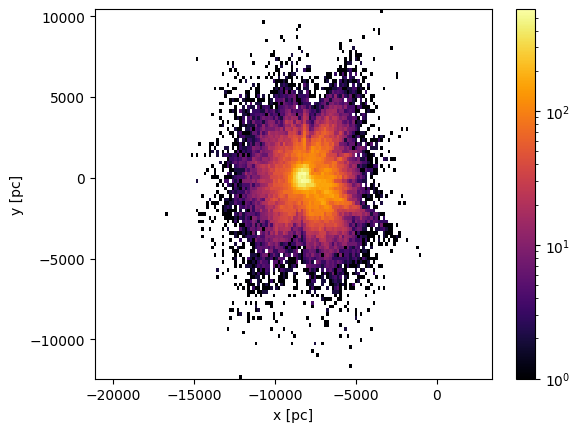

In [5]:
from matplotlib.colors import LogNorm
plt.hist2d(df['D']*df['cosphi'], df['D']*df['sinphi'], bins = (100, 100), norm=LogNorm(), cmap = "inferno")
plt.colorbar()
plt.axis('equal')
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")

In [6]:
def v_mod(par, sinl, cosl, D):
    vrot, u, v, VarIntrinsic = par
    return vrot*sinl*((R/D)-1) - u*cosl - v*sinl

def v_modlin(par,sinl,cosl,D):
    u,v,a,b = par
    return (a*(D/1000)+b)*sinl*((R/D)-1) - u*cosl - v*sinl

def log_like(par, vrad, var_vrad, prop, sinl, cosl, D):
    #vrot, u, v, VarIntrinsic = par
    u,v,a,b = par
    #return -0.5*( np.sum( ((vrad - v_mod(par, sinl, cosl, D))**2)/(var_vrad + (vrot**2)*prop + VarIntrinsic) + np.log(var_vrad + (vrot**2)*prop +VarIntrinsic) ) )
    return -0.5*(np.sum(((vrad - v_modlin(par, sinl, cosl, D))**2)/(var_vrad)))

vgal=200
Vmin = -500
Vmax = 500
MinVarIntrinsic = 0.1
MaxVarIntrinsic = 1000000

# log prior
def log_prior(par):
    #vrot,u,v, VarIntrinsic=par
    u,v,a,b = par
    #if not Vmin<=vrot<=Vmax:
        #return -np.inf
    if not Vmin<=u<=Vmax:
        return -np.inf
    if not Vmin<=v<=Vmax:
        return -np.inf
    #if not MinVarIntrinsic<=VarIntrinsic<=MaxVarIntrinsic:
        #return -np.inf
    if b<=0:
        return -np.inf

    #return -(0.5*(u**2+v**2)/vgal**2) - np.log(np.abs(vrot)) - np.log(VarIntrinsic)
    return -(0.5*(u**2+v**2)/vgal**2)

# log prob
def log_prob(par,vrad,var_vrad,prop,sinl,cosl,D):
    lp=log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(par,vrad,var_vrad,prop,sinl,cosl,D)

## DEMO

Fit Parameters: mu = 0.64, var = 1376.91
LogPrior: -0.01
LogLike: -132838963.34
LogProb: -132838963.34
Average varrad: 2.93


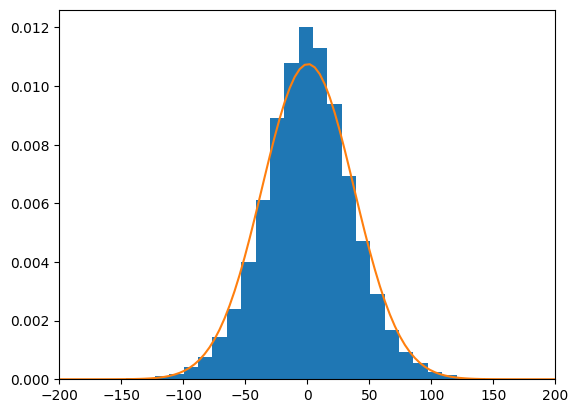

In [ ]:
atry = 10
btry = 130
uTry = 10
vTry = 20

VarIntrinsicTry = 1010

df['vModTry'] = v_mod([uTry, vTry, atry, btry], df['sinl'], df['cosl'], df['D'])
plt.hist(df['vModTry']-df['radial_velocity'], bins=100, density=True);
plt.xlim(-200, 200)

mu, sigma = norm.fit(df['vModTry']-df['radial_velocity'])
plt.plot(np.linspace(-200, 200, 100), norm.pdf(np.linspace(-200, 200, 100), mu, sigma))

print("Fit Parameters: mu = {:.2f}, var = {:.2f}".format(mu, sigma**2))
print("LogPrior: {:.2f}".format(log_prior([uTry, vTry, atry, btry])))
print("LogLike: {:.2f}".format(log_like([uTry, vTry, atry, btry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))
print("LogProb: {:.2f}".format(log_prob([uTry, vTry, atry, btry], df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D'])))

print("Average varrad: {:.2f}".format(np.mean(df['VAR_rad_vel'])))
#print("Average prop*vrot**2: {:.2f}".format(np.mean(df['DER2_Prop_model'])*VrotTry**2))

(-200.0, 200.0)

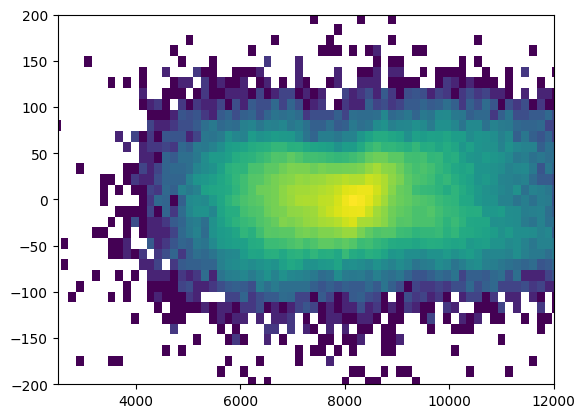

In [19]:
from matplotlib.colors import LogNorm


plt.hist2d(df['D'], df['vModTry']-df['radial_velocity'], bins = (100, 100), norm = LogNorm())
plt.xlim((2500, 12000))
plt.ylim(-200, 200)



In [8]:
import emcee

ndim = 4  
nwalkers = 20
nsteps = 1000 
burnin = 300
U_init = np.random.normal(loc=10, scale=5, size=nwalkers)
V_init = np.random.normal(loc=15, scale=5, size=nwalkers)
A_init =np.random.normal(loc=-10, scale=2, size=nwalkers)
B_init=np.random.normal(loc=200, scale=15, size=nwalkers)

p0 = np.vstack([U_init, V_init, A_init, B_init]).T

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['D']))

sampler.run_mcmc(p0, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

print("Forma dei campioni:", flat_samples.shape)

100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]

Forma dei campioni: (1400, 4)


Text(0.5, 0, 'step number')

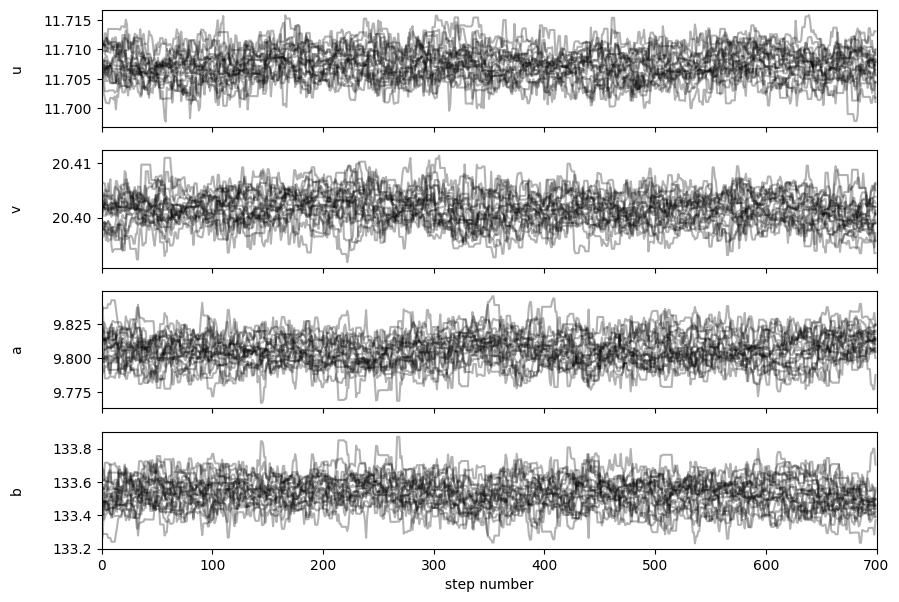

In [9]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
labels = ["u", "v", "a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

(1400, 4)


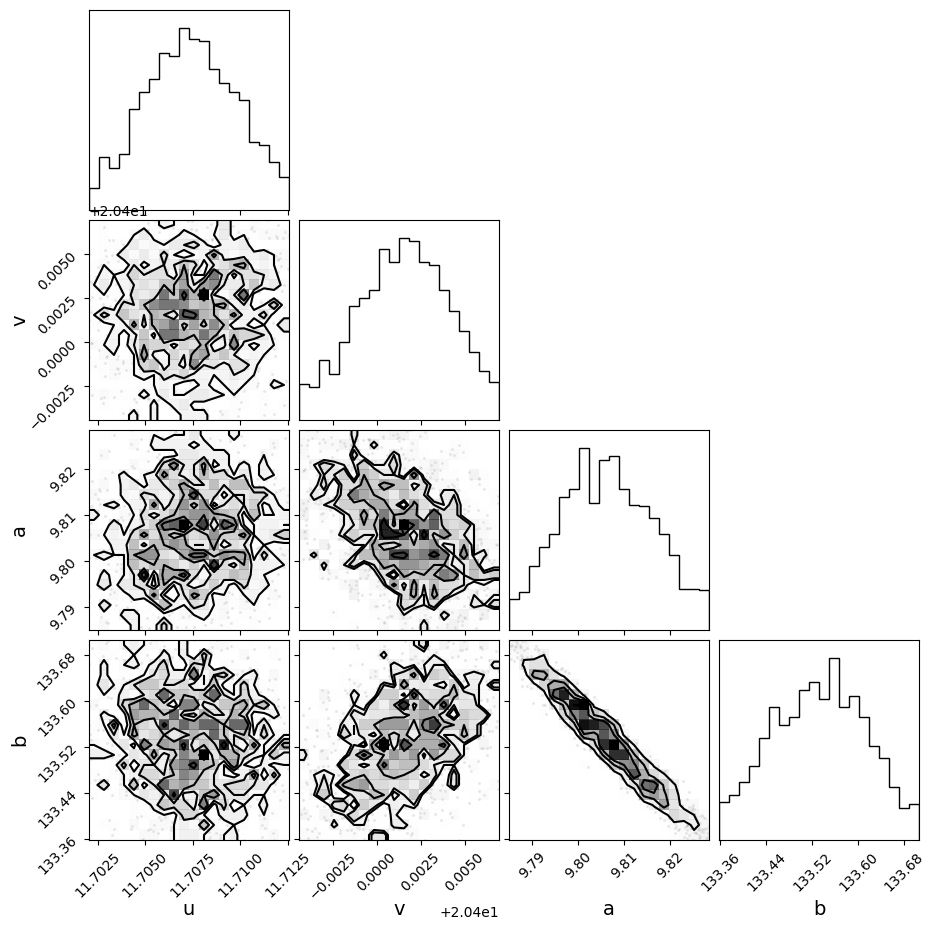

In [10]:
import corner
ranges = []
for i in range(flat_samples.shape[1]):
    lower, upper = np.percentile(flat_samples[:, i], [2.5, 97.5])
    ranges.append((lower, upper))

print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, range=ranges, label_kwargs={"fontsize": 14})